# Collect the dataset

In [7]:
!mkdir -p data
!i=0; for f in $(find /build/hg/xen.git -type f -name "*.c"); do cp $f data/$i.c ; i=$(($i+1)) ; done

# Import the data

Define our dataset.  Note that we need to pad out all the samples in each batch to be the same length.

In [2]:
import torch
import glob
import string
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader


class XenCData(Dataset):
    filenames = []
    allchars = string.printable
    n_letters = len(allchars)
    UNK = n_letters  # 'Unknown character' token
    n_letters = n_letters + 1
    BOF = n_letters  # 'Beginning of file' token
    n_letters = n_letters + 1
    EOF = n_letters  # 'End of file' token
    n_letters = n_letters + 1
    PAD = n_letters  # 'Pad' token (shouldn't be processed)
    n_letters = n_letters + 1

    def __init__(self, folder):
        self.filenames=glob.glob(f"{folder}/*.c")
        print(f"{len(self.filenames)} sample files")
    
    def string_to_array(self, string):
        letter_indexes = []
        for li in range(len(string)):
            ci = self.allchars.find(string[li])
            if ci == -1:
                ci = self.UNK
            letter_indexes.append(ci)
        return letter_indexes

    def __getitem__(self, index):
        file = open(self.filenames[index])
        try:
            data = file.read()
        except:
            print(f"Error processing file {self.filenames[index]}")
        finally:
            file.close()
        
        # Convert the file to straight letter indexes
        raw = self.string_to_array(data)
        
        # Input: BOF + file contents
        # Output: file contents + EOF
        # NB: Embedding() only accepts Long
        x = torch.LongTensor([self.BOF] + raw)
        y = torch.LongTensor(raw + [self.EOF])
        return (x, y)
    
    def pad_collate(self, batch):
        # batch is an array of x/y tuples (where x and y are tensors)
        # Need to merge them into batch-sized padded X and Y tensors
        max_len = max([xy[0].shape[0] for xy in batch])
        #print(f"Padding to {max_len}")
        
        X = []
        Y = []
        
        for i, xy in enumerate(batch):
            (x, y) = xy
            assert x.size(0) == y.size(0), f"Size mismatch: x({x.size(0)}) and y({y.size(0)})"
            
            if x.size(0) < max_len:
                pad_size = list(x.shape)
                pad_size[0] = max_len - x.size(0)
                pad_tensor = torch.ones(*pad_size, dtype=torch.long) * self.PAD
                x = torch.cat([x, pad_tensor], dim=0)
                y = torch.cat([y, pad_tensor], dim=0)
            
            #print(f"Appending element of size {x.size(0)}")
            X.append(x)
            Y.append(y)

        return (torch.stack(X, 0), torch.stack(Y, 0))
    
    # Need to implement colate_fn to pad out individual elements
    def GetLoader(self, **kwargs):
        kwargs["collate_fn"]=self.pad_collate
        return DataLoader(self, **kwargs)
        
    def __len__(self):
        return len(self.filenames)        

And load the data from the file

In [3]:
DATA_FOLDER="data"
dataset = XenCData(DATA_FOLDER)

1002 sample files


Finally creating an iterater to load our training data

In [52]:
loader = dataset.GetLoader(batch_size=1013, shuffle=True)
loaderi = iter(loader)

In [61]:
dataset.filenames = dataset.filenames[:25]

In [203]:
import torch.nn as nn
embedding = nn.Embedding(dataset.n_letters, 8, padding_idx=dataset.PAD)

In [566]:
dataset.allchars

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

# Define the model

In [4]:
import torch.nn as nn
from tqdm import tqdm, tqdm_notebook
from time import time
from math import floor

class CLang(nn.Module):
    
    def __init__(self, dataset, hidden=128, embed_dim=10, layers=3, dropout=0.0):
        super(CLang, self).__init__()
        
        self.embed_dim = embed_dim
        self.lstm_hidden = hidden
        self.lstm_layers = layers
        self.dropout = dropout
        self.dataset = dataset
        
        # [Pipeline] batch x padded_length x 1
        # Embedding: Map characters to am "embedding" to make things easier
        self.embedding = nn.Embedding(self.dataset.n_letters,
                                      self.embed_dim, 
                                      padding_idx=dataset.PAD)
        
        # [Pipeline] batch x padded_length x embed_dim
        # LSTM: Predict output 
        self.lstm = nn.LSTM(input_size=self.embed_dim,
                            hidden_size=self.lstm_hidden,
                            num_layers = self.lstm_layers,
                            batch_first=True,
                            dropout=self.dropout)
        
        # [Pipeline] batch x padded_length x hidden_size
        
        # Decode the lstm cell output to predict the next character
        self.decoder = nn.Linear(self.lstm_hidden, self.dataset.n_letters)
        
        # [Pipeline] batch x padded_length x n_letters
        
        self.softmax = nn.LogSoftmax(dim=2)
        
        # [Pipeline] batch x padded_length x n_letters
        
        self.criterion = nn.NLLLoss(ignore_index=dataset.PAD)
        
    def init_hidden(self, batch_size):
        return (torch.zeros(self.lstm_layers, batch_size, self.lstm_hidden),
                torch.zeros(self.lstm_layers, batch_size, self.lstm_hidden))

    def forward(self, X, hidden):
        embedded = self.embedding(X)
        
        # TODO: pack / unpack batch.  Requires sorting batch by length.
        lstm_out, hidden = self.lstm(embedded, hidden)
        
        decoded = self.decoder(lstm_out)
        output = self.softmax(decoded)
        return output, hidden

In [5]:
crnn = CLang(dataset)
allloss = []

(Testing data loader and batching functionality)

In [386]:
loader = dataset.GetLoader(batch_size=5, shuffle=True)
loaderi = iter(loader)
batch = next(loaderi)
(X, Y) = batch
X.size()

Padding to 20180
Appending element of size 20180
Appending element of size 20180
Appending element of size 20180
Appending element of size 20180
Appending element of size 20180


torch.Size([5, 20180])

(Testing forward propagation)

In [396]:
hidden = crnn.init_hidden(5)
output, hidden = crnn.forward(X, hidden)

(Testing batch training and backpropagation)

In [13]:
allloss = []

In [ ]:
crnn.train_batch(batch)

# Train the model

In [6]:
%matplotlib inline
from IPython.display import display, Code, Pretty
import matplotlib.pyplot as plt
import numpy as np

def train_batch(model, batch, gclip=1.0):
    (X, Y) = batch
        
    assert X.size(0) == Y.size(0)
    batch_size = X.size(0)
        
    hidden = model.init_hidden(batch_size)
        
    #self.zero_grad()
    model.optimizer.zero_grad()
        
    output, hidden = model.forward(X, hidden)
    #Y_onehot = self.onehot(Y)
        
    # NLLLoss expects [seq, vocab, batch] and [seq, batch], so reshape output and Y to fit
    co = output.view(-1, model.dataset.n_letters, batch_size)
    cy = Y.view(-1, batch_size)
    #print(f"co {co.size()} cy {cy.size()}")
    loss = model.criterion(co, cy)
        
    loss.backward()
        
    # Not sure if this is the right place to do this...
    nn.utils.clip_grad_norm_(model.parameters(), gclip)
        
    model.optimizer.step()
        
    return loss.item()

def train(model, losses=[], iterations=5, batch_size=20, lr=0.01, max_code=200, statwindow=500):
    model.optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    bar = tqdm_notebook(range(iterations))
    loss = 0.0
    
    # Get an update-able code object
    fig,axis = plt.subplots(1,1)
    
    stats = display(Pretty(""), display_id=True)
    hist = display(fig, display_id=True)
    code = display(Code(""), display_id=True)
        
    try:
        for i in bar:
            try:
                batch = next(loaderi)
            except:
                #print("Reloading dataset")
                loader = model.dataset.GetLoader(batch_size=batch_size, shuffle=True)
                loaderi = iter(loader)
                batch = next(loaderi)
            
            loss = train_batch(model, batch)
            losses.append(loss)
            
            _sw = statwindow
            if len(losses) < 2*statwindow:
                _sw = len(losses) // 2

            prev = losses[-(2*_sw):-(_sw)]
            recent = losses[-(_sw):]
            recent_mean = np.mean(recent)
            if len(prev) > 0:
                prev_mean = np.mean(prev)
                statstring = "%7d [%0.5f %0.5f %0.5f] [%0.5f %0.5f %0.5f] grad %0.5f" % (len(losses), min(recent), recent_mean, max(recent), min(prev), prev_mean, max(prev), recent_mean-prev_mean)
            else:
                statstring = "%7d [%0.5f %0.5f %0.5f]" % (len(losses), min(recent), recent_mean, max(recent))
            stats.update(Pretty(statstring))
            
            axis.clear()
            axis.hist(prev, 30)
            axis.hist(recent, 30)
            hist.update(fig)
            code.update(Code(generate(model, max_len=max_code), language="C"))

    except KeyboardInterrupt:
        pass
    
    plt.close()
    
    return losses

    266 [2.29215 3.05158 4.38731] [2.71010 3.55382 4.63783] grad -0.50224

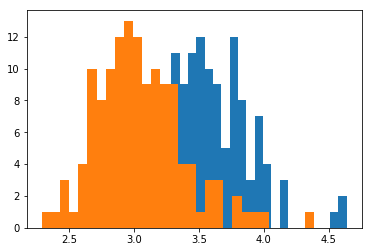

* tand, dpelltuutaifS_von.c, e,)
;        ian oec tvxete. ) rnh_ad oca =
*    
 tdt(EAcO: I                       ant = Siily M= Grrthr aaeof; 
        * &TCVURGEF    
                 soternehrsl[
#inlprn3e af>an) gM;*
*

Error processing file data/xen_drivers_video_font_8x8.c.c


In [13]:
lastloss = train(crnn, losses=allloss, iterations=50000, batch_size=1, lr=0.0032, max_code=500, statwindow=1010)

In [ ]:
dataset.filenames[400:]

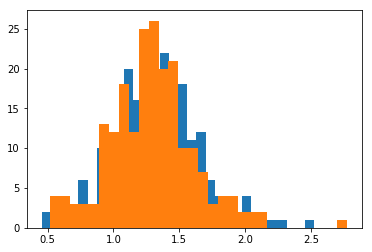

In [374]:
%matplotlib inline
import time

fig,ax = plt.subplots(1,1)

#hist = display(plt.gcf(), display_id=True)
hist = display(fig, display_id=True)

#plt.ion()

#fig.show()
#fig.canvas.draw()

window=int(len(allloss)/10)
for i in range(9):
    a=allloss[i*window:(i+1)*window]
    b=allloss[(i+1)*window:(i+2)*window]
    ax.clear()
    ax.hist(a, 30)
    ax.hist(b, 30)
#    fig.canvas.draw()
#    hist.update(plt.gcf())
    hist.update(fig)

    time.sleep(0.5)
    
plt.close()

In [265]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

#%matplotlib notebook
# Can use 'inline' if notebook turns out to be unweildy
%matplotlib inline

def plot_loss(loss):
    plt.figure(figsize=(10, 5))
    plt.plot(loss)
    if len(loss) > 50:
        window_length=len(loss)/10
        # window_length must be odd
        if (window_length % 2) == 0:
            window_length += 1
        llsmooth = savgol_filter(loss, 301, 3)
        plt.plot(llsmooth)
        


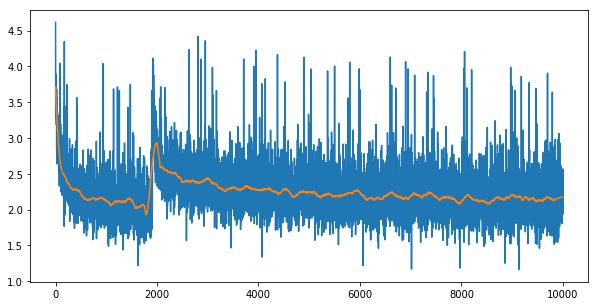

In [82]:
#plot_loss(allloss)
#llsmooth = savgol_filter(lastloss, 51, 3)
# Results for 10k iterations at 0.05 lr

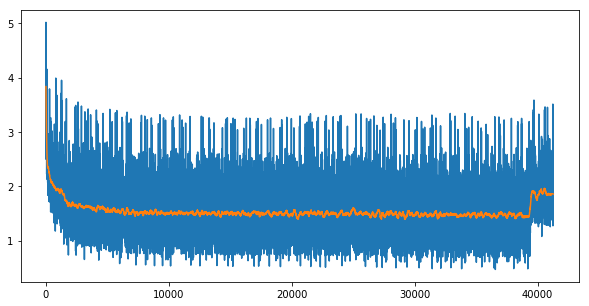

In [304]:
plot_loss(allloss)


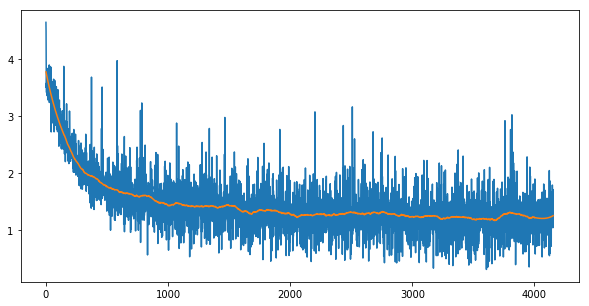

In [383]:
plot_loss(allloss)

Now play around with generation.

In [598]:
hidden = crnn.init_hidden(1)
bofTensor = torch.stack([torch.LongTensor([dataset.BOF])], 0)
with torch.no_grad():
    output, hidden = crnn.forward(bofTensor, hidden)

In [501]:
import numpy as np
olog = np.array(output.view(-1))
oprob = np.exp(olog)
indexes=[]
chars=[]
for i, p in enumerate(oprob):
    if p > 0.1:
        indexes.append(i)
        chars.append(dataset.allchars[i])

In [503]:
chars, indexes

(['#', '/', ' '], [64, 76, 94])

In [507]:
nT = torch.stack([torch.LongTensor([64])], 0)
with torch.no_grad():
    output, hidden = crnn.forward(nT, hidden)

In [601]:
olog = np.array(output.view(-1))
oprob = np.exp(olog)
indexes=[]
chars=[]
probs=[]
for i, p in enumerate(oprob):
    if p > 0.03:
        indexes.append(i)
        chars.append(dataset.allchars[i])
        probs.append(p)
chars, indexes, probs

(['a', 'e', 'n', 'r', 's', ' '],
 [10, 14, 23, 27, 28, 94],
 [0.041075334, 0.05517484, 0.03267741, 0.06107333, 0.030182261, 0.4762688])

In [7]:
import random
import numpy as np

def generate(crnn, min_prob=0.03, max_len=1000):
    # Convert an index into a tensor
    def index_to_input(i):
        return torch.stack([torch.LongTensor([i])], 0)
    
    def weighted_index(weights):
        """ 
        weighted_choice selects a random element of 
        the sequence according to the list of weights
        """
        cum_weight = 0
        x = np.random.random() * sum(weights)
        for i, w in enumerate(weights):
            cum_weight += w
            if x < cum_weight:
                return i
        return len(weights)-1
    
    def weighted_square(weights):
        wsq = weights * weights
        return weighted_index(wsq)
    
    def min_prob_index(oprob):
        """
        min_prob_index filds all indexes with probability over min_prob and selects on of them
        (with equal probability)
        """
        indexes=[]
        chars=[]
        probs=[]
        for i, p in enumerate(oprob):
            if p > min_prob:
                indexes.append(i)
                if i < len(crnn.dataset.allchars):
                    chars.append(crnn.dataset.allchars[i])
                else:
                    chars.append(crnn.dataset.allchars.find('U'))
                probs.append(p)
        #print(indexes, chars, probs)
        assert len(indexes) > 0        
        return indexes[random.randint(0, len(indexes)-1)]
    
    def max_prob_index(oprob):
        return np.argmax(oprob)
    
    def max_or_weight(oprob, maxprob=0.5):
        if np.random.random() < maxprob:
            return max_prob_index(oprob)
        else:
            return weighted_square(oprob)
        
    def multinomial(oprob):
        return torch.multinomial(oprob, 1)[0]
    
    hidden = crnn.init_hidden(1)
    
    outstring=""
    
    # Manually run through the forward-iteration, chosing a new prediction
    nT = index_to_input(crnn.dataset.BOF)
    while True:
        # For some reason, no_grad() and eval() are separate...?
        with torch.no_grad():
            crnn.eval()
            output, hidden = crnn.forward(nT, hidden)
            crnn.train()
        
        # Convert log output to probability
        oprob = np.exp(output.view(-1))
        
        #nI = weighted_square(oprob)
        #nI = weighted_index(oprob)
        #nI = min_prob_index(oprob)
        #nI = max_prob_index(oprob)
        #nI = max_or_weight(oprob)
        nI = multinomial(oprob)


        if nI == crnn.dataset.EOF:
            break
            
        nC = -1

        if nI < len(crnn.dataset.allchars):
            nC = crnn.dataset.allchars[nI]
        else:
            # Theoretically should only be UNK, but there's always
            # a small possibility of PAD or BOF
            nC = "U"
        
        outstring += nC
        
        if len(outstring) >= max_len:
            break
        
        nT = index_to_input(nI)
        
    return outstring

In [35]:
crnn.embedding

Embedding(104, 10, padding_idx=103)

# Save the model parameters

In [38]:
MODELPATH="XenLSTMv1.pt"
torch.save(crnn.state_dict(), MODELPATH)

In [9]:
MODELPATH="XenLSTMv1.pt"
crnn_trained = CLang(dataset)
crnn_trained.load_state_dict(torch.load(MODELPATH))

In [16]:
s = generate(crnn_trained, max_len=2000)
display(Code(s, language="C"))

/*
 *  Limpleted\n"
		 *data offset */
		cpu->rsixalloc.value;

		if (hshut_count_index) {
			dt_esel.bldup-2 	= '\0';
					break;
	case 'n':
		if (off_write(str->flag)) {
			return cur_init;
	}

	for (i = 0; i < mem_len : TERC_PURRESE;

	/note->fs.slit = entry;
}

int __init test_cooc_replace(struct iommu_asid *freq,
		    struct xs_tvb_states tm_sp,
                                           libxl__vs_andic_timer, int strstatus, int mem_id,
                              libxl_interval)
{
    struct suct *ch = vioapic;
    h->pts[1] = NULL;
    struct xs_daemonation *v;
    schedule_cached_fd = disk_enabled(d);

    if ( iommu_vcpu_iables )
        return call_fpus;
    struct gicv3_signal_iomp = nics;
    int nb, d->sm_set_caches->compati0[cr4s;
    char *s <= symachdomain_vcpu_is_perm(name, size);
    int ret = EFI_EN1_CCST64; *pt = cts->script->mbs_witrib;
    unsigned int fsi;
    uint32_t value;

    xfree(str[8], 20);
    poll_write = gic_policy_value;
    error = {
      "\n"
      "-1 fmoms notifiers is one memory sets a core_arch is text");
    if (rwinit) > report_irq_dispose_to_post_processor_id();
    unsigned long ioprocessor = pir_id;
    int callsob, "voidules[mapnod:\n";

    veriod_delp = vcpu_initver_io_write(slen,*p.c, 14, buf, &instance);
    list_for_each_mask(&cur->new_page->name);
    return defBLOAXENT

 for (n;  * ((cur << d) << sizeof(frame);
#ifdef dotring_hokeled = VIRITS;

cr_file: disk_path=
typedef event_tteq;
}

int opdimstup_ioreq_stream_parking_info(struct cpu_unit_node *fmem)
{
   config = entry;
} _builinit_info_t *data.ops = 0;
scan_size SESTOR_BYCEG_OPS := (mask_aeqereb)
	{
		mmio_initian = gicv3_dpc_disabled();

	}
		return count;
	} else
	  = h->shanghls[j];
	va_unlock_del(unsigned long)->ops + 1);

	rc = xce->fd;

	raw = counter_cl1tmp_fiq);
}

# Do some analysis on the embedding

First, primary component analyses (PCA)

In [42]:
crnn.embedding.weight

Parameter containing:
tensor([[-0.1753, -0.2979, -1.2205,  ...,  1.1830,  0.2313, -0.1628],
        [-0.4732, -0.2335,  0.2250,  ..., -0.2136, -0.1916,  0.0461],
        [ 0.1719, -0.1708,  0.5430,  ...,  1.6358, -0.1213, -0.7390],
        ...,
        [ 0.7171, -0.4804,  0.5936,  ...,  1.2846,  2.3877, -0.1654],
        [ 0.3106,  0.9411,  0.5767,  ..., -2.0849, -0.7162,  0.9476],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [80]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(crnn.embedding.weight.detach())

pca.explained_variance_ratio_

array([0.17234603, 0.13668721])

<IPython.core.display.Javascript object>


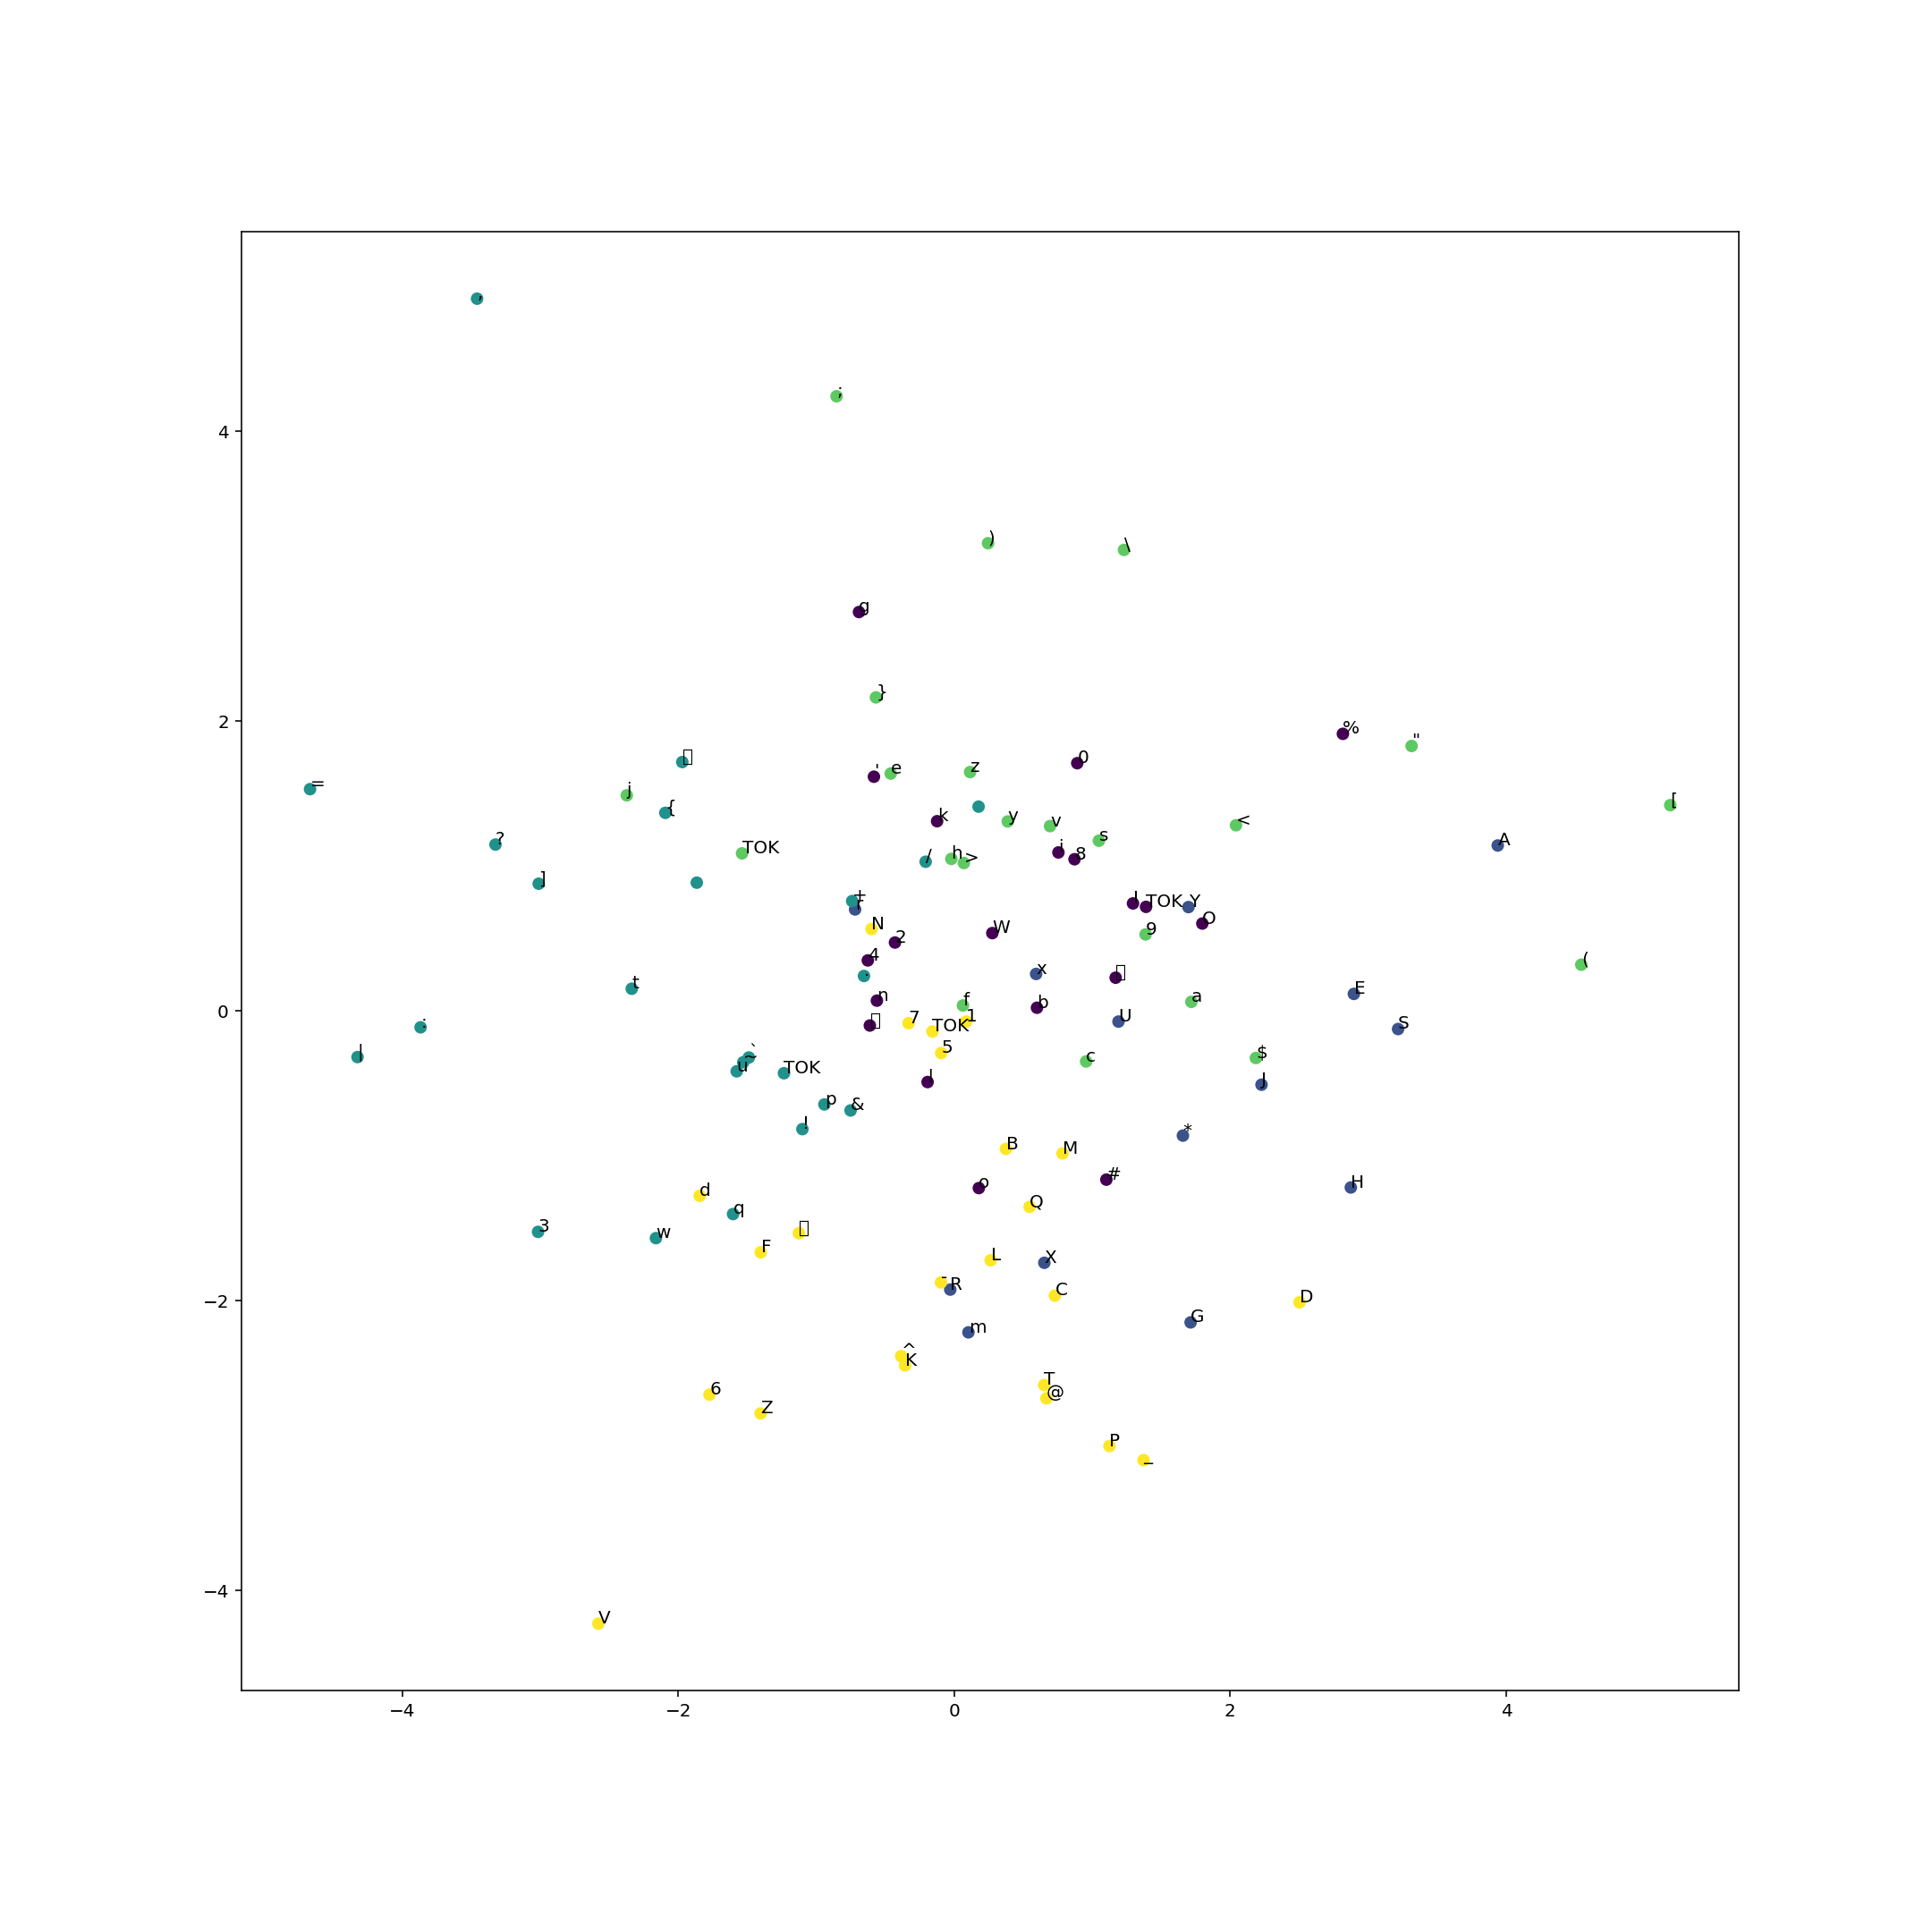

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

%matplotlib notebook

fig = plt.figure()
fig.set_size_inches(15, 15)

#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)


#ax.scatter(pca_result[:,0], pca_result[:,1], marker=".")
ax.scatter(pca_result[:,0], pca_result[:,1], c=cluster_labels)

#ax.scatter(pca_result[:,0], pca_result[:,1], pca_result[:, 2])


for i, _ in enumerate(pca_result[:,0]):
    ds = crnn.dataset
    l = "TOK"
    if i < len(ds.allchars):
        l = ds.allchars[i]
    ax.annotate(l, (pca_result[i,0], pca_result[i,1]))
    #ax.annotate(l, (pca_result[i,0], pca_result[i,1], pca_result[i,2]))

In [17]:
import time
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, n_iter=3000)
tsne_result = tsne.fit_transform(crnn.embedding.weight.detach())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 104 samples in 0.000s...
[t-SNE] Computed neighbors for 104 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 104 / 104
[t-SNE] Mean sigma: 2.285423
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.817535
[t-SNE] KL divergence after 1700 iterations: 0.619067


<IPython.core.display.Javascript object>


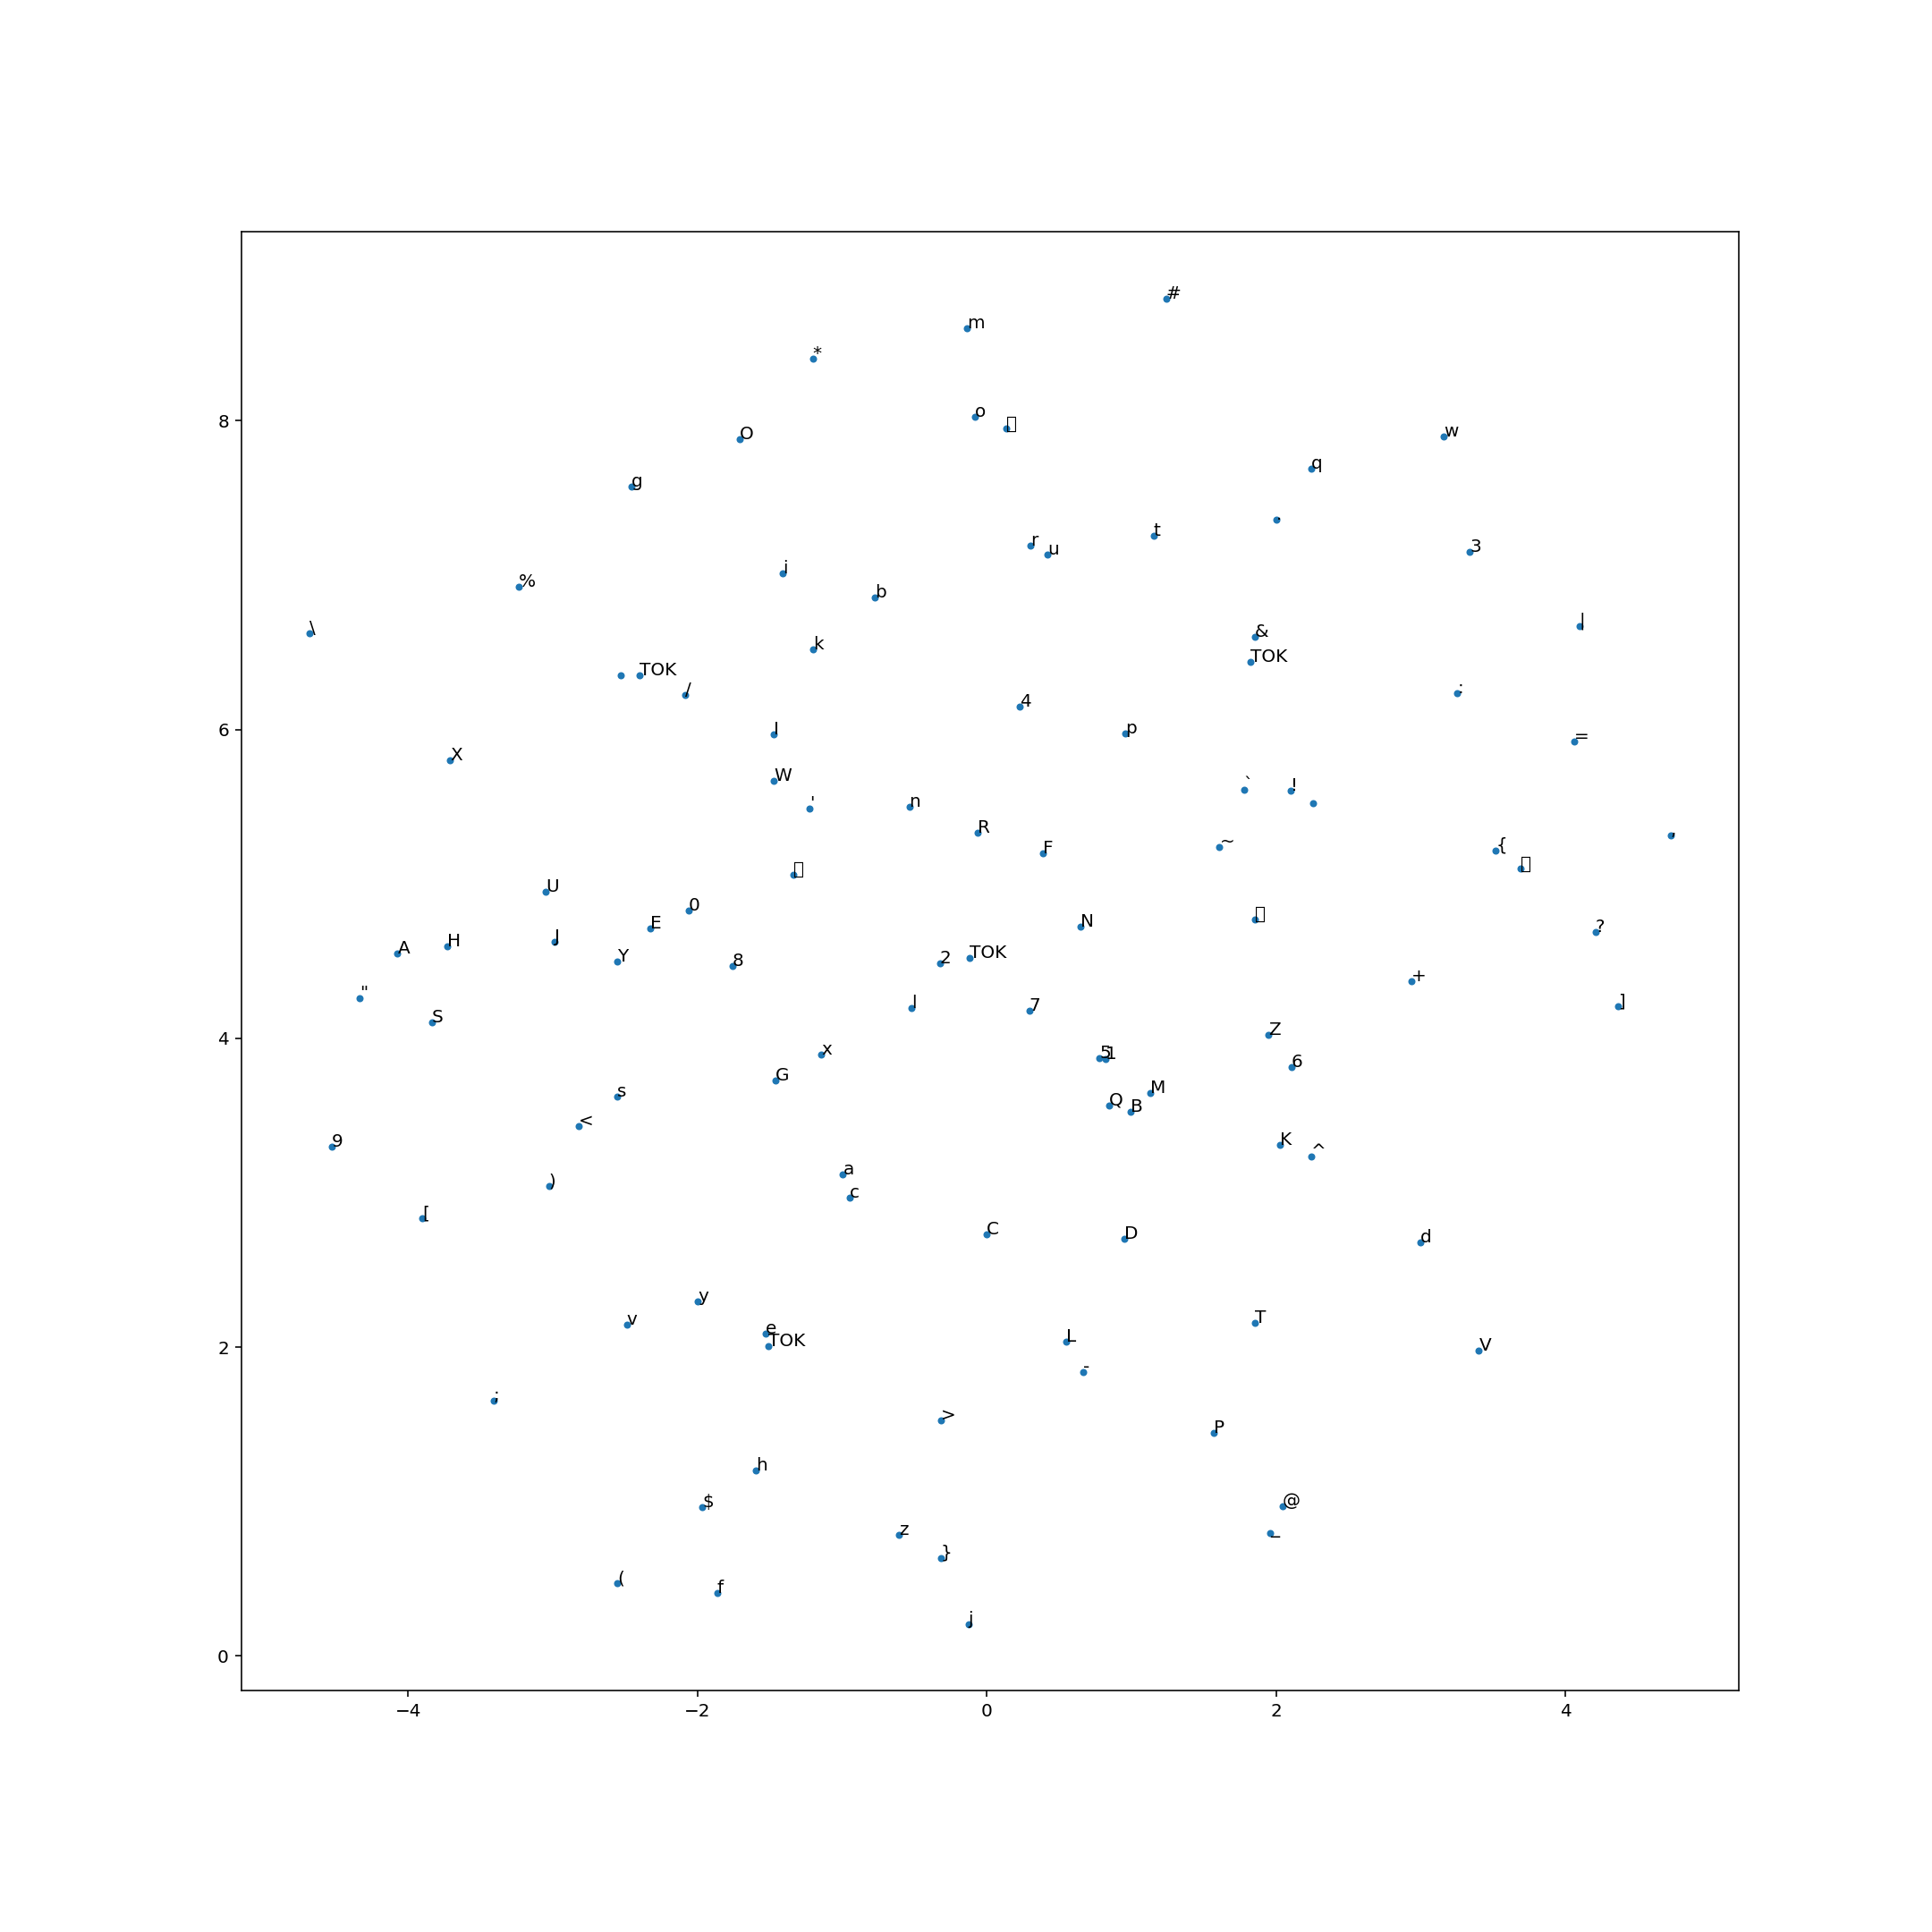

In [59]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

%matplotlib notebook

fig = plt.figure()
fig.set_size_inches(15, 15)

#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)


ax.scatter(tsne_result[:,0], tsne_result[:,1], marker=".")
#ax.scatter(pca_result[:,0], pca_result[:,1], pca_result[:, 2])


for i, _ in enumerate(tsne_result[:,0]):
    ds = crnn.dataset
    l = "TOK"
    if i < len(ds.allchars):
        l = ds.allchars[i]
    ax.annotate(l, (tsne_result[i,0], tsne_result[i,1]))
    #ax.annotate(l, (pca_result[i,0], pca_result[i,1], pca_result[i,2]))

Now, K-means clustering.

First, see if we can find an "elbow point":

<IPython.core.display.Javascript object>


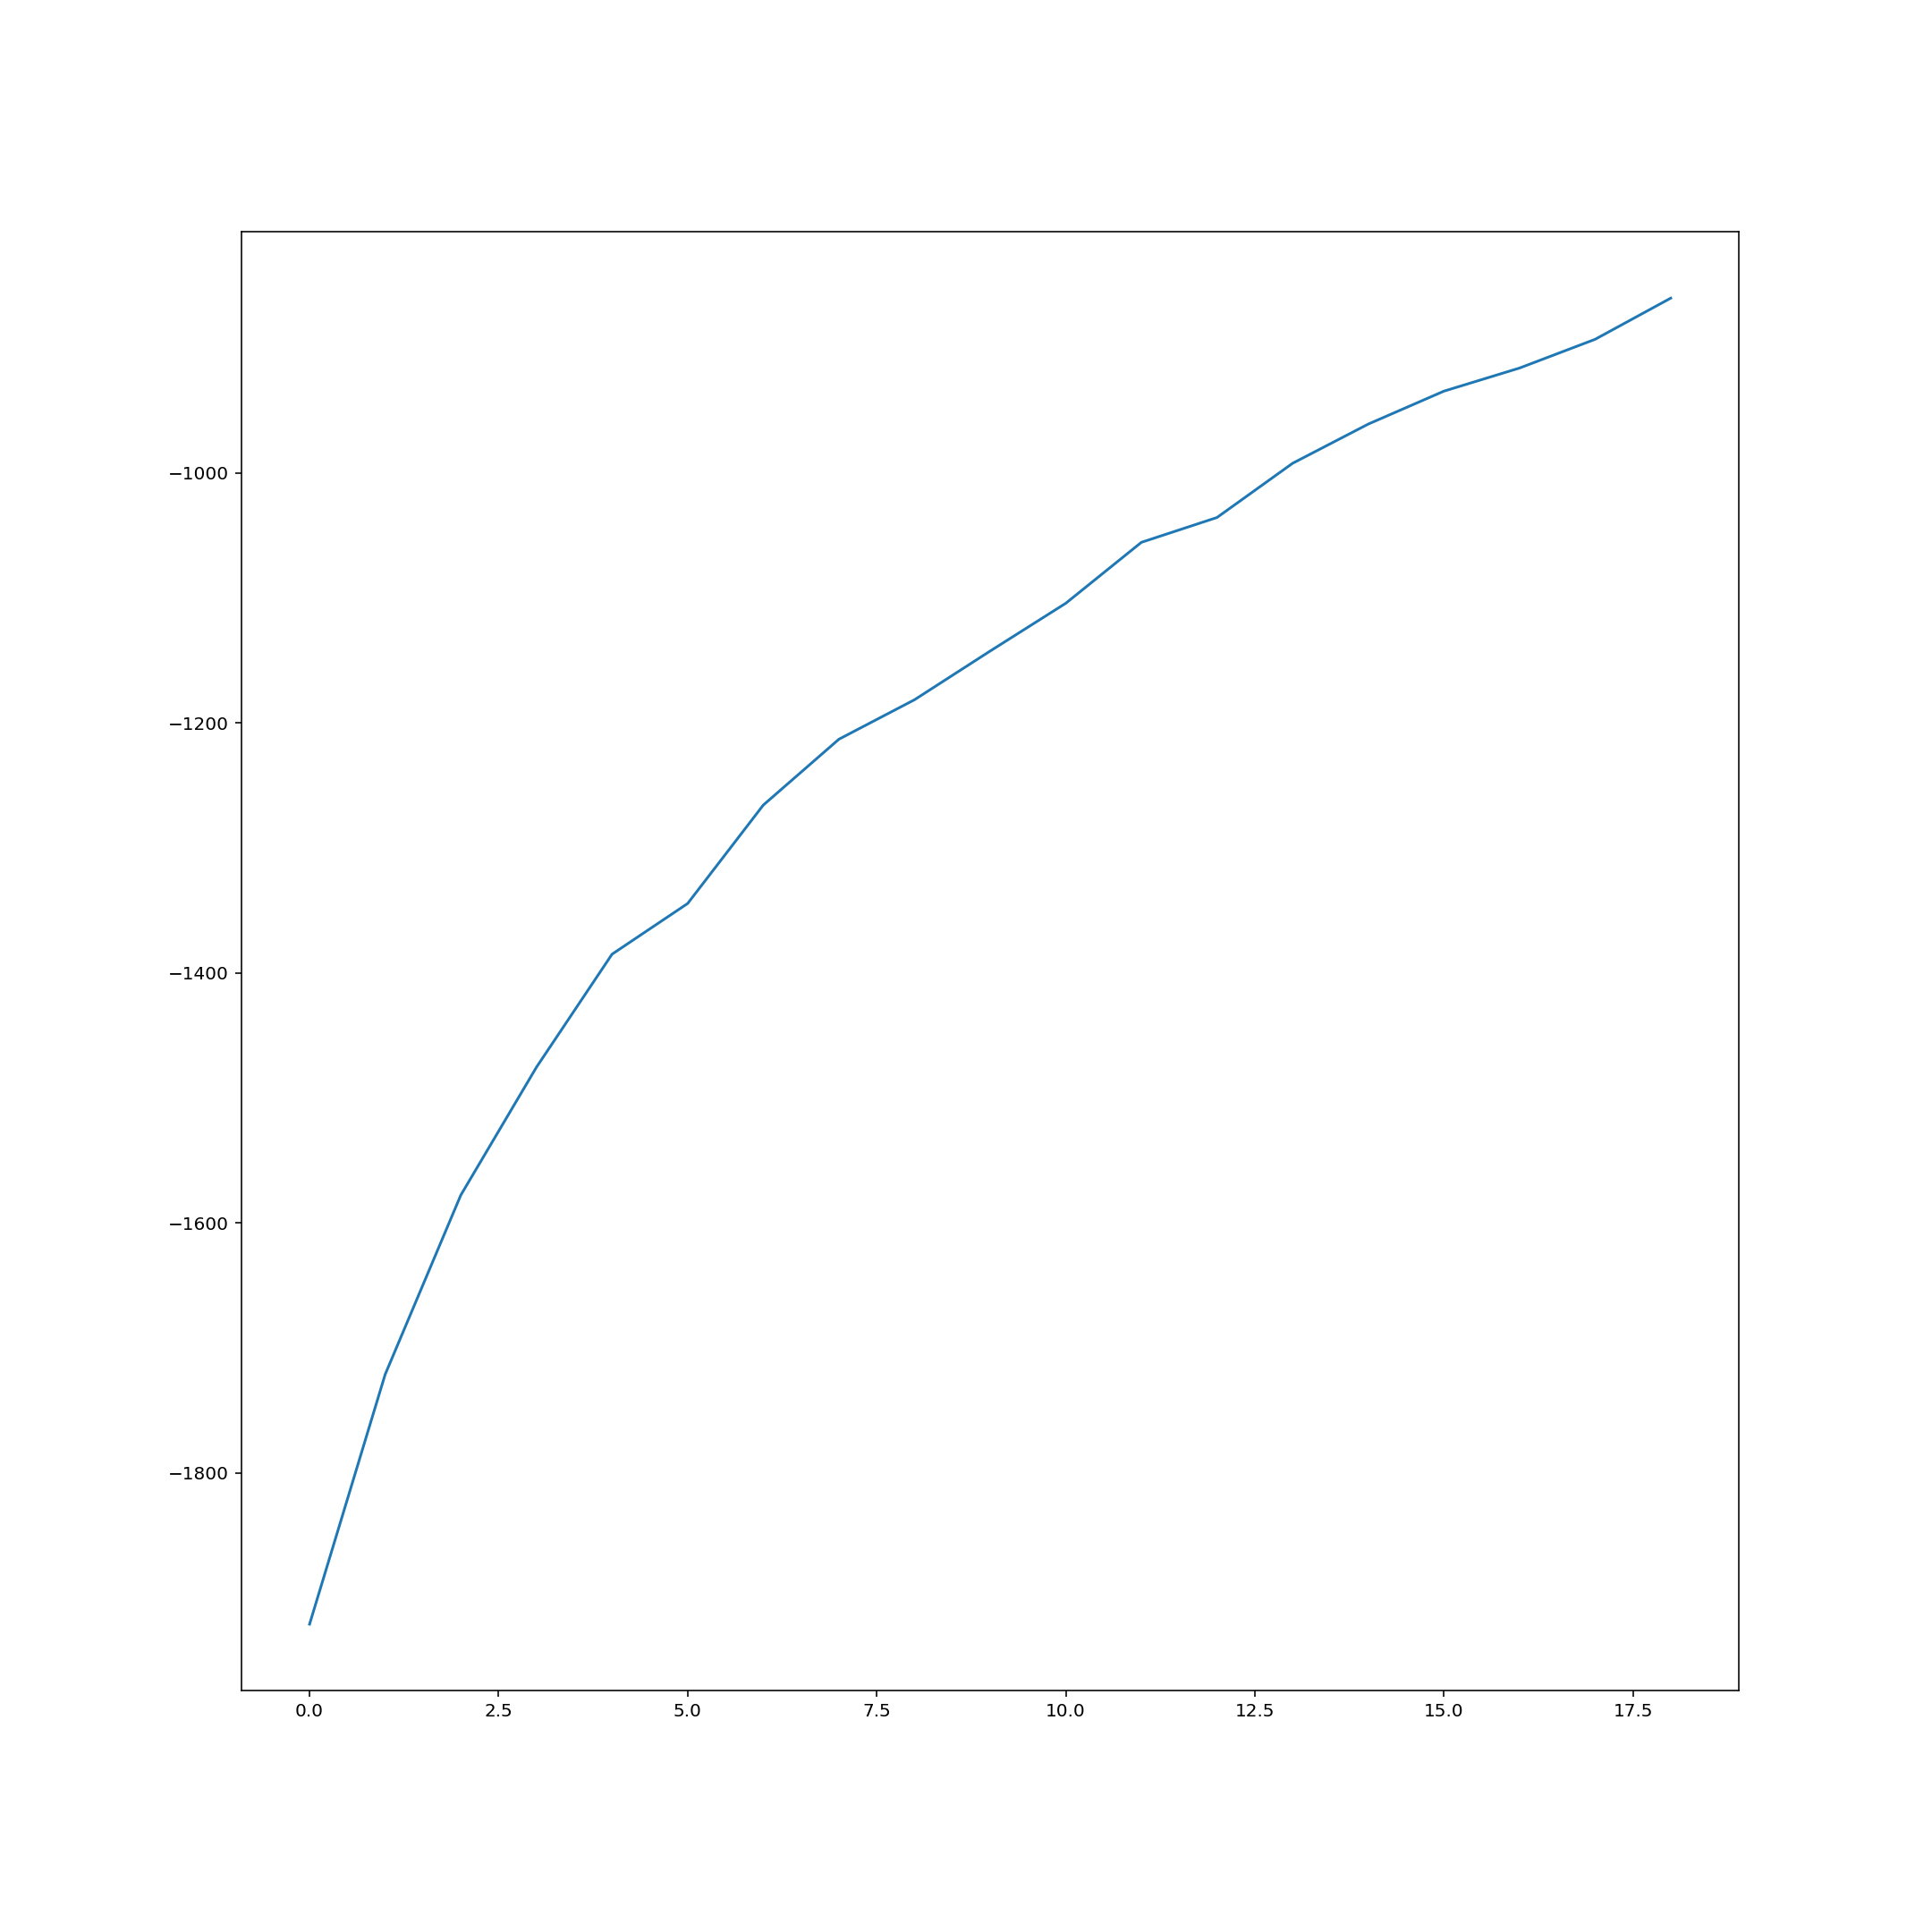

In [25]:
from sklearn.cluster import KMeans

scores = []
for clusters in range(19):
    kmeans = KMeans(n_clusters=clusters+1)
    kmeans = kmeans.fit(crnn.embedding.weight.detach())
    scores.append(kmeans.score(crnn.embedding.weight.detach()))
    
fig = plt.figure()
fig.set_size_inches(15, 15)

#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)
ax.plot(scores)

Hmm, not really.  5 (4 + 1) is the closest option.  Let's see what that kind of clustering gets us:

In [67]:
nclusters=5
kmeans = KMeans(n_clusters=nclusters)
kmeans = kmeans.fit(crnn.embedding.weight.detach())
cluster_labels = kmeans.predict(crnn.embedding.weight.detach())

In [68]:
tokens = [[] for _ in range(nclusters)]
for c in range(nclusters):
    for i in range(len(cluster_labels)):
        if cluster_labels[i] == c:
            l = "TOK"
            if i < len(crnn.dataset.allchars):
                l = crnn.dataset.allchars[i]
            tokens[c].append(l)

for c in range(len(tokens)):
    print(tokens[c])

['1', '5', '7', 'b', 'e', 'f', 'h', 'p', 'y', 'B', 'D', 'K', 'M', 'O', 'Q', '$', '(', '+', '^']
['3', '6', 'd', 'q', 'w', 'C', 'F', 'L', 'P', 'T', 'V', 'Z', '!', '&', '-', '@', '_', '`', '|', '~', '\t', 'TOK']
['j', 't', ')', ',', ':', ';', '=', '?', ']', '{', ' ', '\r', 'TOK']
['0', '8', '9', 'a', 'k', 's', 'v', 'z', 'A', 'H', 'J', 'S', 'U', 'X', 'Y', '"', '.', '/', '<', '>', '[', '}', '\n', 'TOK']
['2', '4', 'c', 'g', 'i', 'l', 'm', 'n', 'o', 'r', 'u', 'x', 'E', 'G', 'I', 'N', 'R', 'W', '#', '%', "'", '*', '\\', '\x0b', '\x0c', 'TOK']


We seem to have numbers, capital letters, lower-case letters, and symbols spread about evenly through the 5 sets; this corresponds to the idea that the embedding is simply spreading things out as randomly as possible

<IPython.core.display.Javascript object>


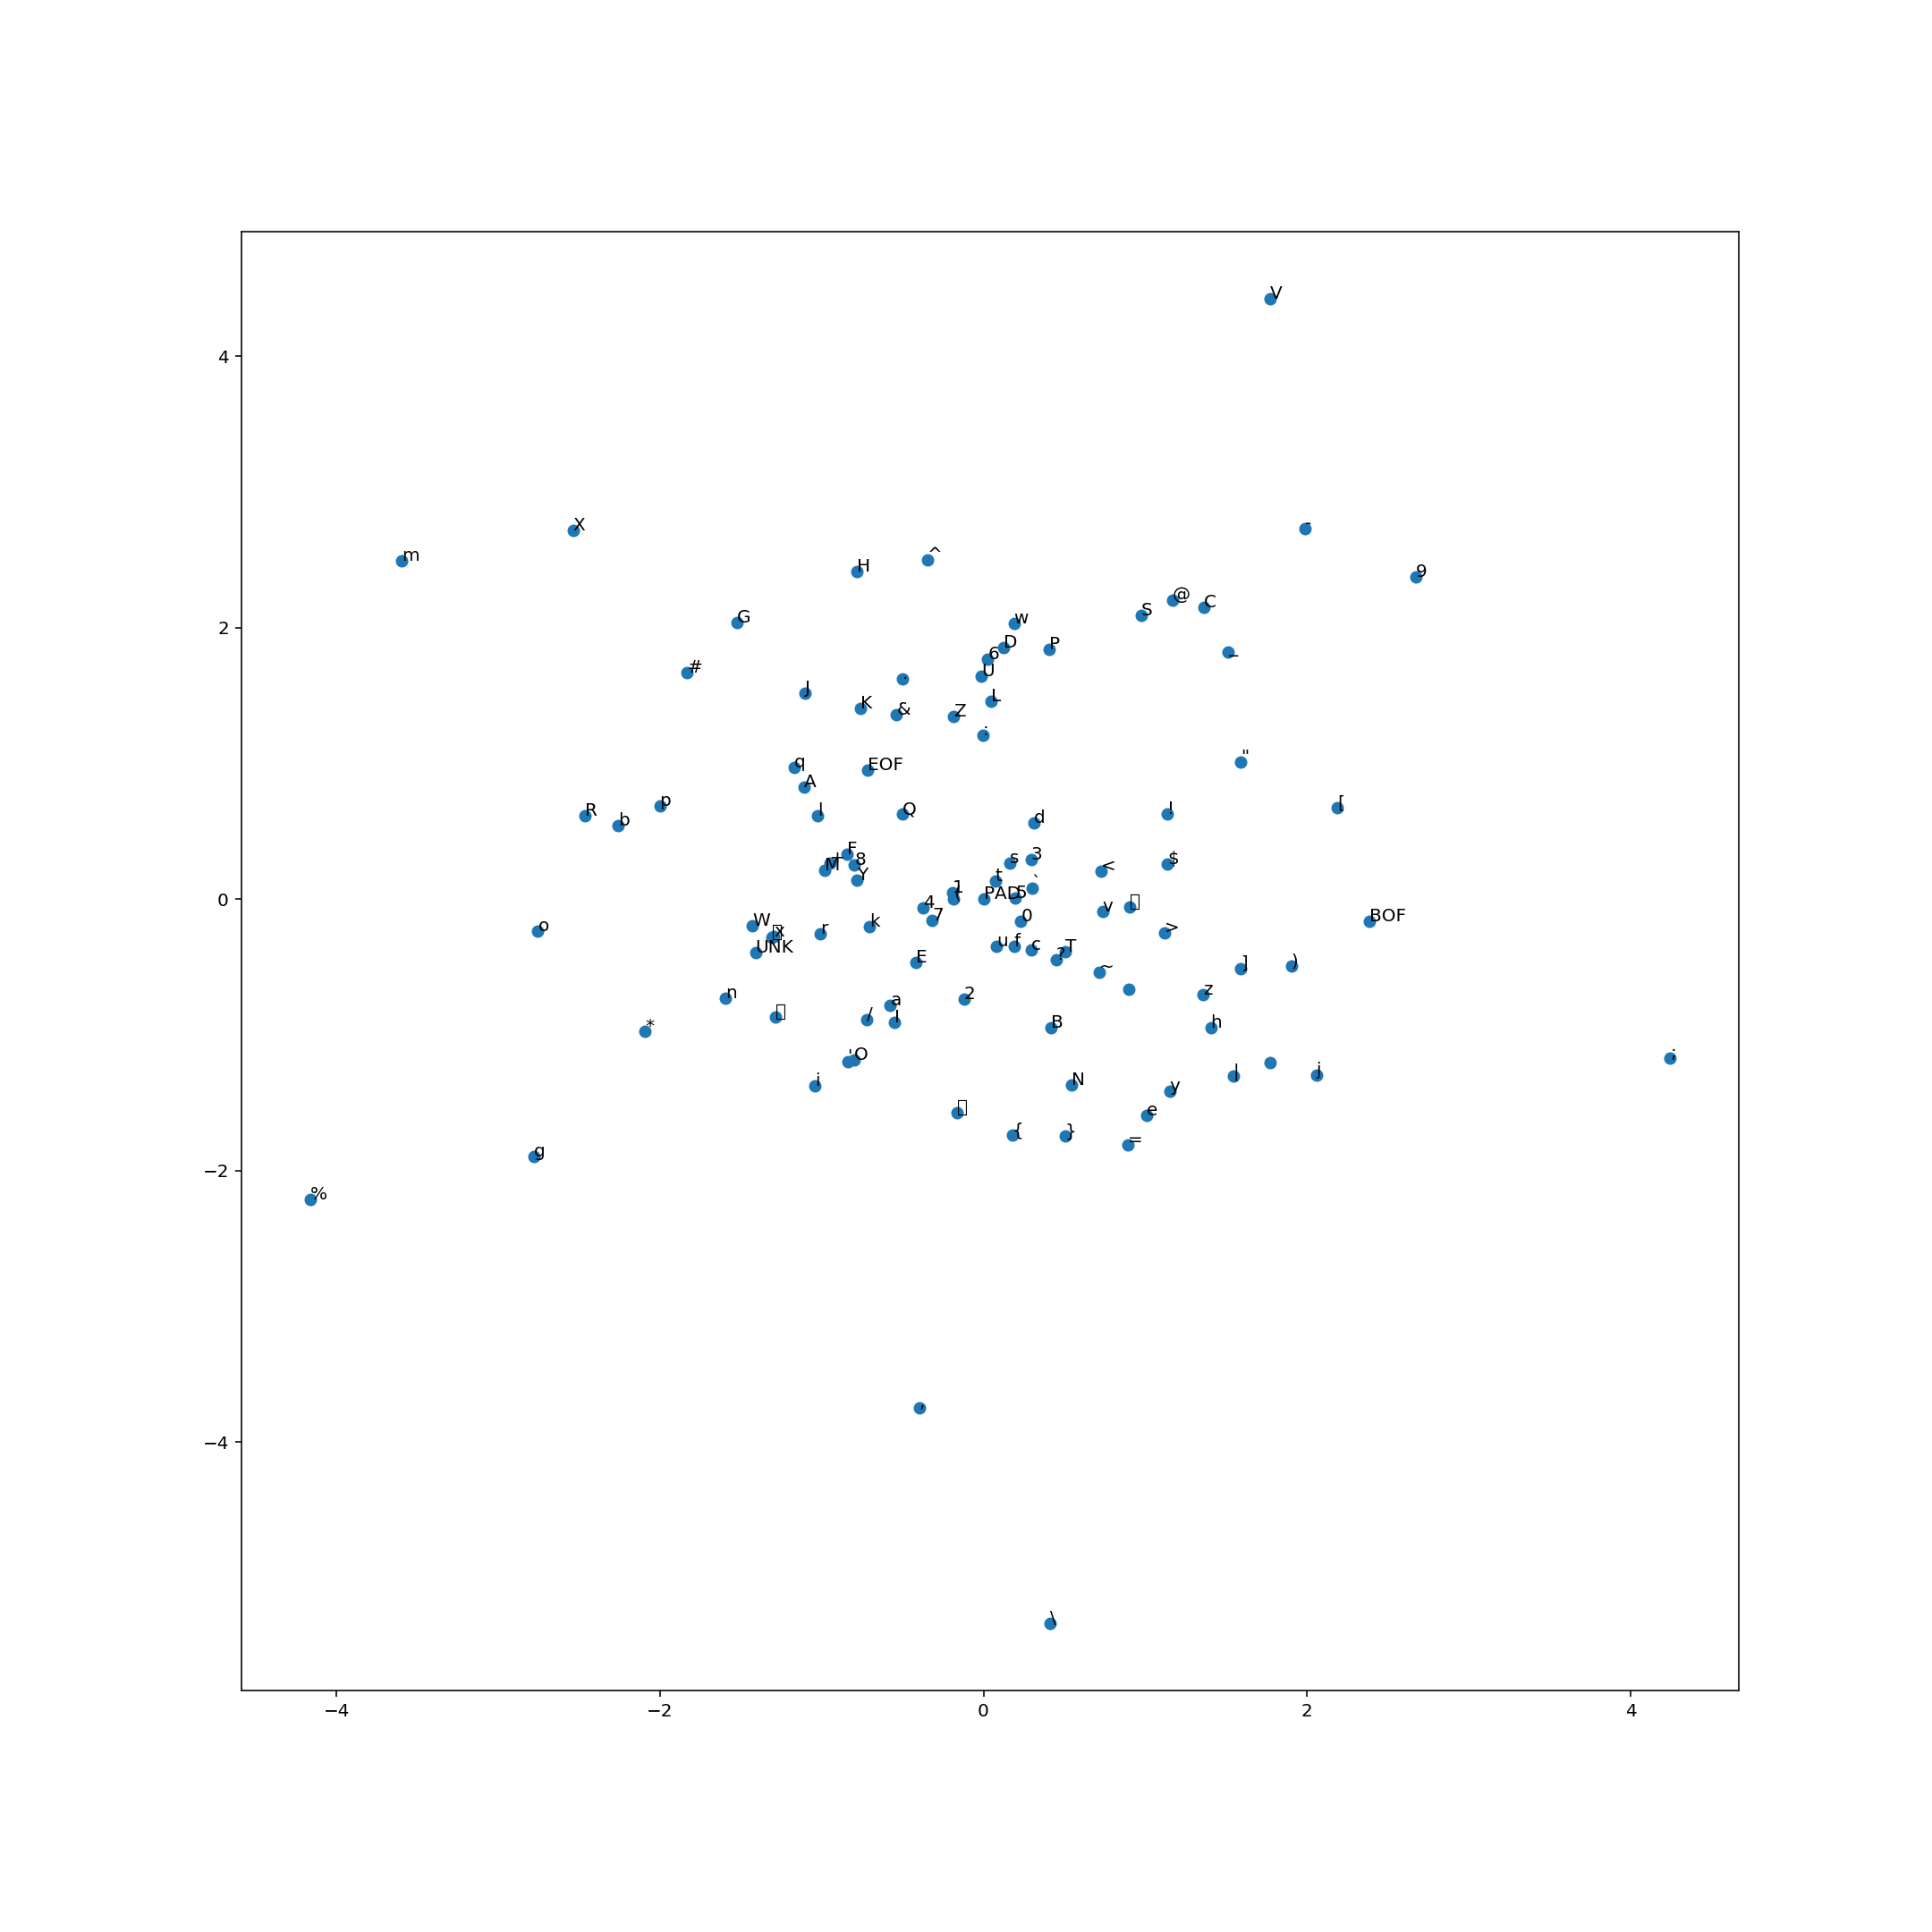

In [79]:
def index_to_label(ds, i):
    l = "TOK"
    if i < len(ds.allchars):
        l = ds.allchars[i]
    elif i == ds.BOF:
        l = "BOF"
    elif i == ds.EOF:
        l = "EOF"

    elif i == ds.UNK:
        l = "UNK"

    elif i == ds.PAD:
        l = "PAD"
    return l


embedding = crnn.embedding.weight.detach()
et = embedding.t()

x = et[8]
y = et[9]

import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import axes3d

%matplotlib notebook

fig = plt.figure()
fig.set_size_inches(15, 15)

#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)


#ax.scatter(pca_result[:,0], pca_result[:,1], marker=".")
ax.scatter(x, y)

#ax.scatter(pca_result[:,0], pca_result[:,1], pca_result[:, 2])


for i, _ in enumerate(x):
    ax.annotate(index_to_label(crnn.dataset, i), (x[i], y[i]))
    #ax.annotate(l, (pca_result[i,0], pca_result[i,1], pca_result[i,2]))
